# The task

The risk manager has collected data on the loan borrowers (https://cdn.theforage.com/vinternships/companyassets/Sj7temL583QAYpHXD/JiwEkbBq8pFwMRYLc/1684245611456/Task%203%20and%204_Loan_Data.csv). The data is in tabular format, with each row providing details of the borrower, including their income, total loans outstanding, and a few other metrics. There is also a column indicating if the borrower has previously defaulted on a loan. You must use this data to build a model that, given details for any loan described above, will predict the probability that the borrower will default (also known as PD: the probability of default). Use the provided data to train a function that will estimate the probability of default for a borrower. Assuming a recovery rate of 10%, this can be used to give the expected loss on a loan.

- You should produce a function that can take in the properties of a loan and output the expected loss.
- You can explore any technique ranging from a simple regression or a decision tree to something more advanced. You can also use multiple methods and provide a comparative analysis.

# Data exploration

## Quick overview

First, I will explore the dataset. The high-level summary of the data:

- There is an id column called customer_id. I set it as the index because it won't help us on prediction.
- There are three columns with data type float64: loan_amt_outstanding, total_debt_outstanding, and income. This means they are contiuous numerical variables.
- The rest are four columns with data type int64: credit_lines_outstanding, years_employed, fico_score, default. This means they are likely discrete numerical variables.

In [1]:
import pandas as pd
import matplotlib.pyplot as plt

In [2]:
borrowers = pd.read_csv('./Task 3 and 4_Loan_Data.csv')
borrowers.set_index('customer_id', inplace=True)
borrowers.info()

<class 'pandas.core.frame.DataFrame'>
Index: 10000 entries, 8153374 to 5533570
Data columns (total 7 columns):
 #   Column                    Non-Null Count  Dtype  
---  ------                    --------------  -----  
 0   credit_lines_outstanding  10000 non-null  int64  
 1   loan_amt_outstanding      10000 non-null  float64
 2   total_debt_outstanding    10000 non-null  float64
 3   income                    10000 non-null  float64
 4   years_employed            10000 non-null  int64  
 5   fico_score                10000 non-null  int64  
 6   default                   10000 non-null  int64  
dtypes: float64(3), int64(4)
memory usage: 625.0 KB


In [3]:
borrowers.describe()

,credit_lines_outstanding,loan_amt_outstanding,total_debt_outstanding,income,years_employed,fico_score,default
count,10000.000000,10000.000000,10000.000000,10000.000000,10000.000000,10000.000000,10000.000000
mean,1.461200,4159.677034,8718.916797,70039.901401,4.552800,637.557700,0.185100
std,1.743846,1421.399078,6627.164762,20072.214143,1.566862,60.657906,0.388398
min,0.000000,46.783973,31.652732,1000.000000,0.000000,408.000000,0.000000
25%,0.000000,3154.235371,4199.836020,56539.867903,3.000000,597.000000,0.000000
50%,1.000000,4052.377228,6732.407217,70085.826330,5.000000,638.000000,0.000000
75%,2.000000,5052.898103,11272.263740,83429.166133,6.000000,679.000000,0.000000
max,5.000000,10750.677810,43688.784100,148412.180500,10.000000,850.000000,1.000000


## The target of the preditive model

This task is about predicting the probability of default on the loan of each borrower in the dataset. The dataset provides a column 'default' indicating whether a borrower has previously defaulted a loan (0: no, 1: yes). We can see that 18.51% borrowers have defaulted before. However, the dataset doesn't have a target column indicating whether a borrower defaulted on the loan shown in the data. Therefore we don't have a direct target to build a supervised predictive model. What we can do is to make an assumption: a borrower has defaulted before is more likely to default again. Then we can use the 'default' column as the target to build the supervised predictive model.

In [4]:
borrowers.default.value_counts()

default
0    8149
1    1851
Name: count, dtype: int64

## Metrics to measure the model performance

Before we build model, we need to be clear what metrics are the best to measure the model performance. The selection of metrics is related to the business case. Here we are talking about a loan business. The total loan applications are sum of good loan applicants (negative default) and bad applicants (positive default). We find good applicants (true negative: TN) and give the loan but miss some good ones (false positive: FP). Likewise, we reject bad applicants (true positive: TP) but make mistakes and cause bad loan (false negative: FN). The performance of the business will be measured with:

- maximise true positive rate TPR = TP/(TP+FN) to minimise loss
- minimise false positive rate FPR = FP/(FP+TN) to maximise profit/gain
- TN volume (profit) > FN volume (loss), otherwise we go bankrupt by excessive debt

We know that the first two bullet points together mean higher ROC AUC score, and the third point mean higher negative predictive value (NPV = TN/(TN+FN)). I will use these two quantities to evaluate the model performance.

## Features

For any predictive model, the independent variables or features decide the predictive power. The dataset provides 6 features that are likely related to the default risk. First I will check these feature data's quality by plotting their histogram to show their distribution. Then I will check their correlation with the target.

The plots indicate that most data have normal like distribution except credit_lines_outstanding and total_debt_outstanding are right-skewed. But this makes perfect sense because most people will have small amount of outstanding credit lines and outstanding total debt. The correlation calculation shows that the default risk is highly positively correlated with outstanding credit lines (0.86) and outstanding total debt (0.76), but only very weakly correlated with income (0.02), and has moderate negative correlation with years_employed and fico_score. These all make sense. If we plot the histograms of credit_lines_outstanding and total_debt_outstanding by target, we will see how they can be used to predict the default probability.

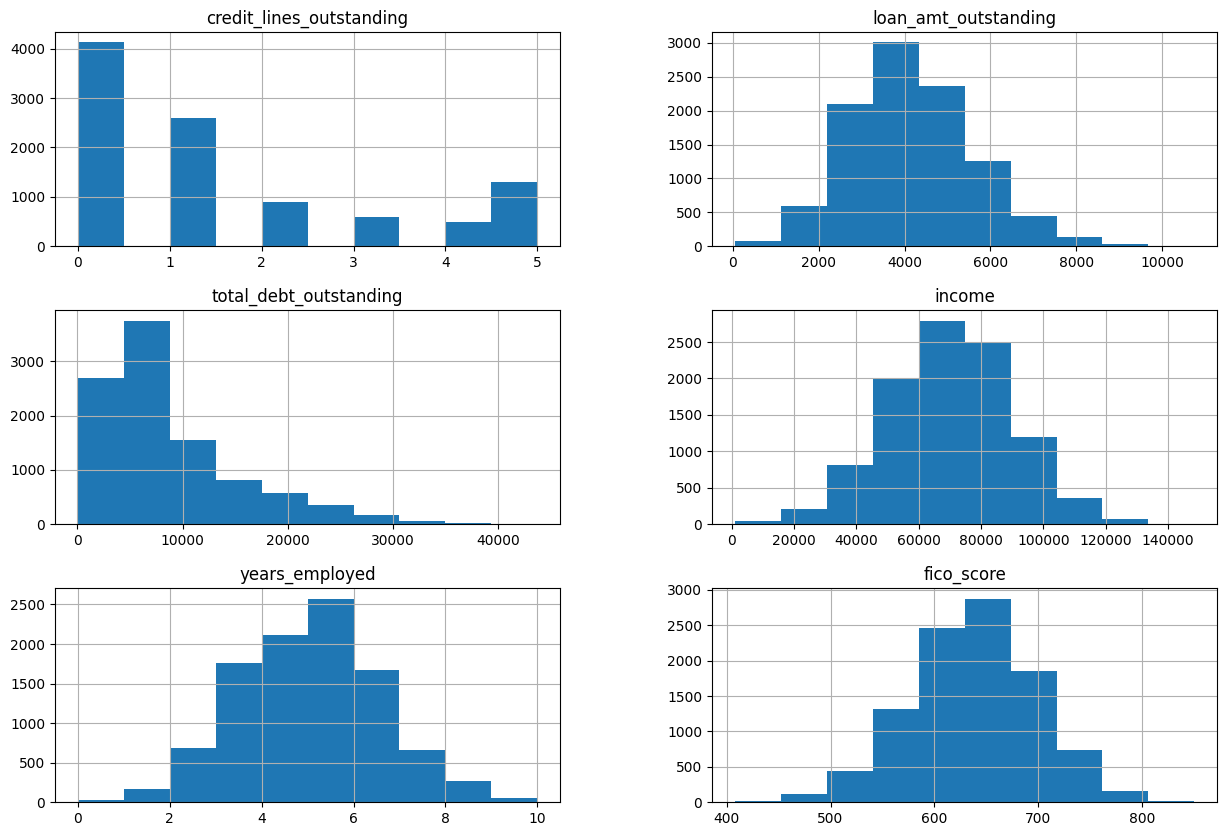

In [5]:
# histogram of all independent variables columns
columns = ['credit_lines_outstanding', 'loan_amt_outstanding', 'total_debt_outstanding',
           'income', 'years_employed', 'fico_score']
borrowers.hist(column=columns, figsize=(15, 10), layout=(3, 2))
plt.show()

In [6]:
borrowers.corr()

,credit_lines_outstanding,loan_amt_outstanding,total_debt_outstanding,income,years_employed,fico_score,default
credit_lines_outstanding,1.000000,0.080249,0.852210,0.022272,-0.087900,-0.258177,0.862815
loan_amt_outstanding,0.080249,1.000000,0.397403,0.835815,-0.158416,-0.031373,0.098978
total_debt_outstanding,0.852210,0.397403,1.000000,0.394397,-0.174353,-0.232246,0.758868
income,0.022272,0.835815,0.394397,1.000000,0.001814,-0.010528,0.016309
years_employed,-0.087900,-0.158416,-0.174353,0.001814,1.000000,0.255873,-0.284506
fico_score,-0.258177,-0.031373,-0.232246,-0.010528,0.255873,1.000000,-0.324515
default,0.862815,0.098978,0.758868,0.016309,-0.284506,-0.324515,1.000000


In [7]:
def hist_by_target(feature, xlabel):
    plt.hist(borrowers[feature][borrowers['default'] == 0], bins=50, label='no default')
    plt.hist(borrowers[feature][borrowers['default'] == 1], bins=50, alpha=0.7, label='default')
    plt.xlabel(xlabel)
    plt.ylabel('Frequency')
    plt.legend()
    plt.show()

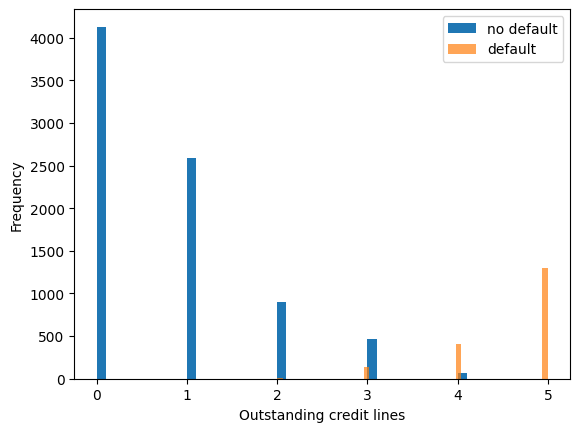

In [8]:
hist_by_target(feature='credit_lines_outstanding', xlabel='Outstanding credit lines')

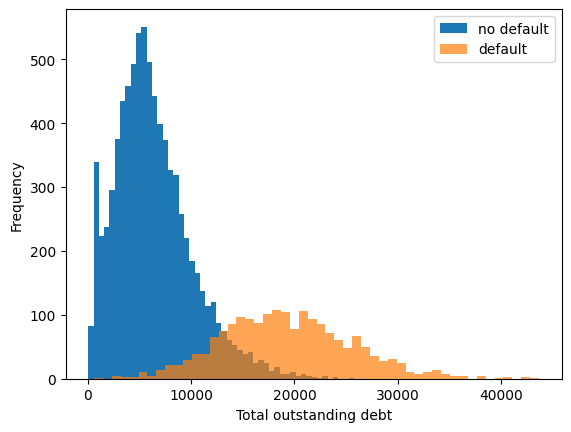

In [9]:
hist_by_target(feature='total_debt_outstanding', xlabel='Total outstanding debt')

# Build predictive models

## Random Forest model using the original features

Let's build a Random Forest model using these original features first. We have known that the target variable is imbalanced between the two outcomes. I handle this imbalance by setting up the class_weight parameter as 'balanced'. As Sklearn doesn't have a function to calculate the NPV, I use the precision_score by setting the parameter pos_label=0 to calculate NPV. I also plot the feature imporance at the end.

In [10]:
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score, roc_auc_score, roc_curve, precision_score

In [11]:
def rf_model(x, y):
    x_train, x_test, y_train, y_test = train_test_split(x, y, test_size=0.3, random_state=0, stratify=y)
    # set class_weight='balanced' to handle the target imbalance
    rf = RandomForestClassifier(n_estimators=200, random_state=0, class_weight='balanced')
    rf.fit(x_train, y_train)
    y_pred = rf.predict(x_test)
    print(f"The confusion matrix is: \n{pd.crosstab(y_pred, y_test, rownames=['y_pred'], colnames=['y_test'])}")
    print("----------------------------------------------------------------------------------------------")
    print(f"The prediction accuracy is: {accuracy_score(y_test, y_pred)}")
    print("----------------------------------------------------------------------------------------------")
    y_pred_prob = rf.predict_proba(x_test)[:, 1]
    print(f"The ROC AUC score is: {roc_auc_score(y_test, y_pred_prob)}")
    fpr, tpr, thresholds = roc_curve(y_test, y_pred_prob)
    plt.plot(fpr, tpr)
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.show()
    print("----------------------------------------------------------------------------------------------")
    print(f"The NPV is: {precision_score(y_test, y_pred, pos_label=0)}")
    print("----------------------------------------------------------------------------------------------")
    print(f"The feature importance:")
    sorted_idx = rf.feature_importances_.argsort()
    rf.feature_importances_[sorted_idx]
    plt.barh(rf.feature_names_in_[sorted_idx], rf.feature_importances_[sorted_idx])
    plt.show()
    return rf

The confusion matrix is: 
y_test     0    1
y_pred           
0       2441    8
1          4  547
----------------------------------------------------------------------------------------------
The prediction accuracy is: 0.996
----------------------------------------------------------------------------------------------
The ROC AUC score is: 0.9998957239448036


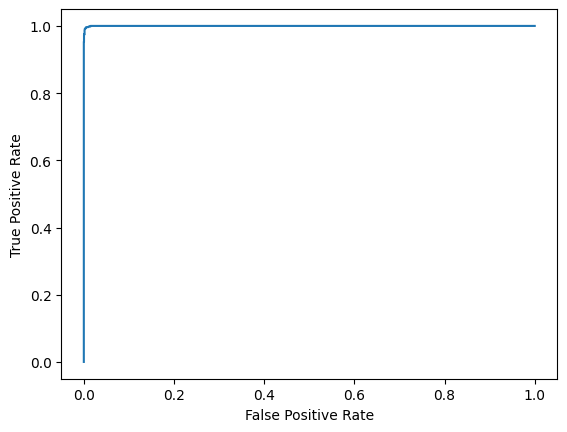

----------------------------------------------------------------------------------------------
The NPV is: 0.9967333605553287
----------------------------------------------------------------------------------------------
The feature importance:


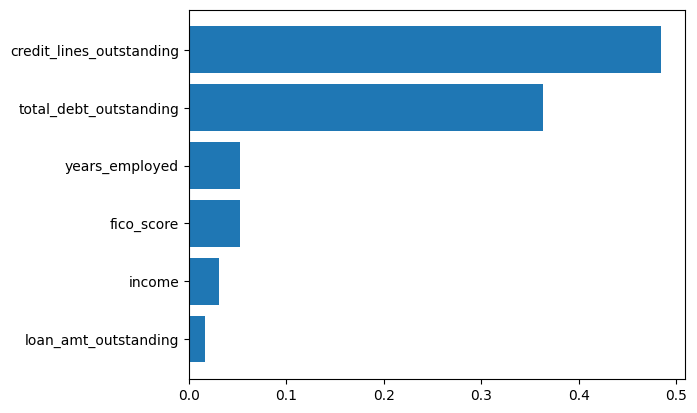

In [12]:
ml_x = borrowers.loc[:, ['credit_lines_outstanding', 'years_employed', 'fico_score', 'loan_amt_outstanding', 
                            'total_debt_outstanding', 'income']]
ml_y = borrowers.default
rf = rf_model(x=ml_x, y=ml_y)

## Random Forest using constructed features

The results above are very impressive. The order of feature imporance is largely consistent with the correlation except that the income feature is more important than the outstanding loan amount even thought its correlation with default is lower. This is probably because the income is not directly correlated with default, but it may have indirect impact on default. If we think about the reality, it is probably not the absolute outstanding total debt amount that have big impact on default, but the ratio between debt and income. The same logic may apply to the loan. The other interesting thing I have found about the data is the loan should be part of the total debt, but some loan amount is actually bigger than the total debt amount. I don't understand the underline reason, but this may have implications to default too. Based on this, I have constructed three new features: debt_income_ratio, loan_income_ratio, and loan_debt_ratio. The good news is that no income or total outstanding debt is 0, and so we do not need to worry about the divided by zero problem.

After I construct the new features, I calculate their correlations with default. We can see that debt_income_ratio has the highest correlation with default. The histogram plot shows that it has much better prediction power than the total outstanding debt alone. I train a new Random Forest model using the same hyper-parameters but the new features. All the key metrics are improved compared with the model using the original features. I will use this new model to calculate the default probability required by the task.

In [13]:
borrowers['debt_income_ratio'] = borrowers['total_debt_outstanding'] / borrowers['income']
borrowers['loan_income_ratio'] = borrowers['loan_amt_outstanding'] / borrowers['income']
borrowers['loan_debt_ratio'] = borrowers['loan_amt_outstanding'] / borrowers['total_debt_outstanding']

In [14]:
borrowers.corr()

,credit_lines_outstanding,loan_amt_outstanding,total_debt_outstanding,income,years_employed,fico_score,default,debt_income_ratio,loan_income_ratio,loan_debt_ratio
credit_lines_outstanding,1.000000,0.080249,0.852210,0.022272,-0.087900,-0.258177,0.862815,0.957247,0.115691,-0.417438
loan_amt_outstanding,0.080249,1.000000,0.397403,0.835815,-0.158416,-0.031373,0.098978,0.087028,0.518645,0.050657
total_debt_outstanding,0.852210,0.397403,1.000000,0.394397,-0.174353,-0.232246,0.758868,0.890775,0.113582,-0.475493
income,0.022272,0.835815,0.394397,1.000000,0.001814,-0.010528,0.016309,0.019682,-0.010875,-0.002492
years_employed,-0.087900,-0.158416,-0.174353,0.001814,1.000000,0.255873,-0.284506,-0.194562,-0.299698,-0.028182
fico_score,-0.258177,-0.031373,-0.232246,-0.010528,0.255873,1.000000,-0.324515,-0.256868,-0.042127,0.068359
default,0.862815,0.098978,0.758868,0.016309,-0.284506,-0.324515,1.000000,0.852406,0.162815,-0.276289
debt_income_ratio,0.957247,0.087028,0.890775,0.019682,-0.194562,-0.256868,0.852406,1.000000,0.132254,-0.538511
loan_income_ratio,0.115691,0.518645,0.113582,-0.010875,-0.299698,-0.042127,0.162815,0.132254,1.000000,0.101987
loan_debt_ratio,-0.417438,0.050657,-0.475493,-0.002492,-0.028182,0.068359,-0.276289,-0.538511,0.101987,1.000000


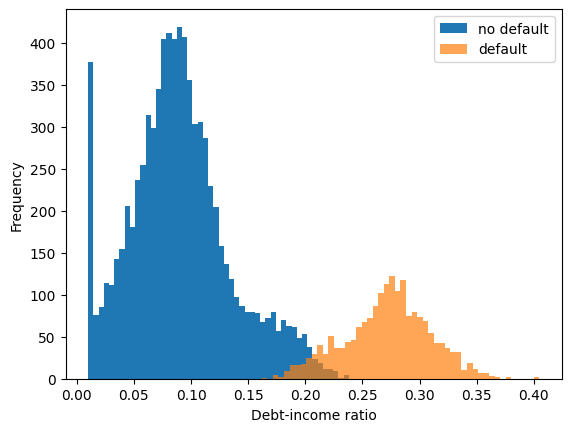

In [15]:
hist_by_target(feature='debt_income_ratio', xlabel='Debt-income ratio')

The confusion matrix is: 
y_test     0    1
y_pred           
0       2443    7
1          2  548
----------------------------------------------------------------------------------------------
The prediction accuracy is: 0.997
----------------------------------------------------------------------------------------------
The ROC AUC score is: 0.9999041986772048


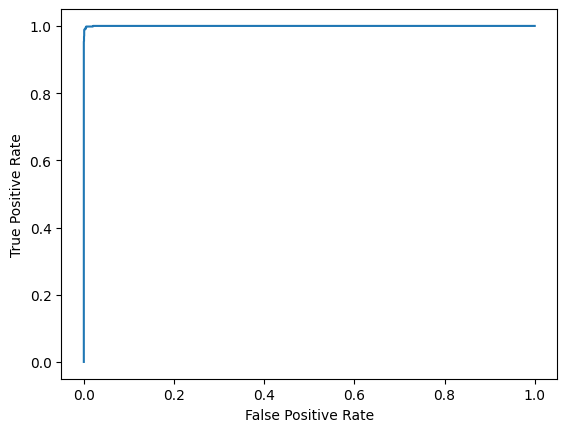

----------------------------------------------------------------------------------------------
The NPV is: 0.9971428571428571
----------------------------------------------------------------------------------------------
The feature importance:


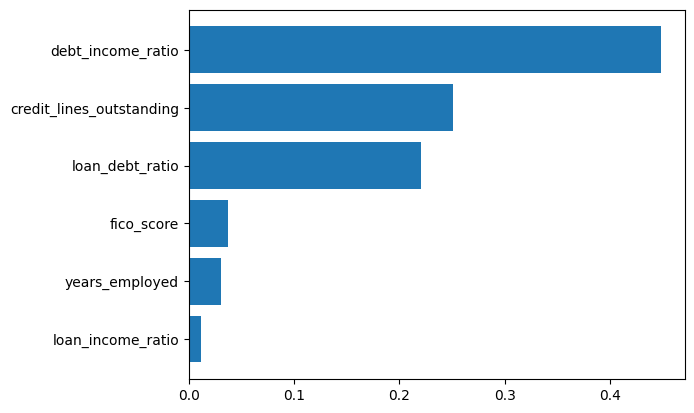

In [16]:
ml_x = borrowers.loc[:, ['credit_lines_outstanding', 'years_employed', 'fico_score', 'debt_income_ratio', 
                            'loan_income_ratio', 'loan_debt_ratio']]
rf = rf_model(x=ml_x, y=ml_y)

# Prediction using the model

Here I will use the Random Forest model trained with the new features to predict each loan's probability of default. Assuming a recovery rate of 10%, I can calculate the expected loss on each loan.

In [17]:
borrowers['PD'] = rf.predict_proba(ml_x)[:, 1]
borrowers['loss'] = 0.9 * borrowers['loan_amt_outstanding'] * borrowers['PD']

In [18]:
borrowers.loc[(borrowers.PD < 1) & (borrowers.PD > 0)].shape

(974, 12)

In [19]:
borrowers.loc[borrowers.PD == 1].shape

(1389, 12)

In [20]:
borrowers.loc[borrowers.PD == 0].shape

(7637, 12)

In [21]:
borrowers.loc[borrowers.PD > 0.5].shape

(1846, 12)

In [22]:
# False positive
borrowers.loc[(borrowers.PD > 0.5) & (borrowers.default == 0)]

,credit_lines_outstanding,loan_amt_outstanding,total_debt_outstanding,income,years_employed,fico_score,default,debt_income_ratio,loan_income_ratio,loan_debt_ratio,PD,loss
customer_id,,,,,,,,,,,,
2542510,3,4423.176239,15960.80903,71290.43771,4,646,0,0.223884,0.062044,0.277127,0.680,2706.983858
5422028,2,4262.123372,11957.06926,54446.94660,1,701,0,0.219610,0.078280,0.356452,0.645,2474.162617


In [23]:
# False negative
borrowers.loc[(borrowers.PD < 0.5) & (borrowers.default == 1)]

,credit_lines_outstanding,loan_amt_outstanding,total_debt_outstanding,income,years_employed,fico_score,default,debt_income_ratio,loan_income_ratio,loan_debt_ratio,PD,loss
customer_id,,,,,,,,,,,,
7557552,2,3076.130524,8759.332341,54099.80079,1,485,1,0.161911,0.056860,0.351183,0.130,359.907271
8384861,5,2352.477472,20029.735720,90501.39682,8,715,1,0.221320,0.025994,0.117449,0.390,825.719593
5413266,3,6814.880770,14767.881450,81128.43182,3,635,1,0.182031,0.084001,0.461466,0.460,2821.360639
7584220,3,7303.442763,17645.242590,101841.27160,4,501,1,0.173262,0.071714,0.413904,0.440,2892.163334
6983390,3,3146.790022,10713.656050,56549.72405,2,648,1,0.189455,0.055646,0.293718,0.405,1147.004963
4931509,4,6210.527299,15934.825280,86397.68250,5,555,1,0.184436,0.071883,0.389746,0.370,2068.105591
5150971,4,1750.854887,7792.681291,37608.07056,4,657,1,0.207208,0.046555,0.224679,0.400,630.307759
